In [1]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering

In [3]:
timeMatrix = pd.read_csv('C:/Users/Aidan/OneDrive - Simon Fraser University (1sfu)/Garbage Route Optimization/timeMatrix.csv', index_col=0)

In [1]:
zones = pd.read_csv('C:/Users/Aidan/OneDrive - Simon Fraser University (1sfu)/Garbage Route Optimization/poco-allzones.csv', index_col=0)

NameError: name 'pd' is not defined

In [7]:
zones.index = zones.index + ', Port Coquitlam, BC, Canada'

In [8]:
zones = zones[(zones['Garbage Zone'] == 4) | (zones['Garbage Zone'] == 5)]

In [9]:
timeMatrix = timeMatrix.iloc[timeMatrix.index.isin(zones.index),timeMatrix.index.isin(zones.index)]

In [4]:
t = timeMatrix
# t = timeMatrix

In [5]:
from sklearn.preprocessing import normalize
t = normalize(t)

In [6]:
from scipy.cluster.hierarchy import ClusterWarning
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)
model = AgglomerativeClustering(n_clusters=5, affinity='euclidean', 
                                linkage='average')
model.fit_predict(t)
labels = model.labels_

In [8]:
clusters = pd.DataFrame({'cluster':labels, 'address':timeMatrix.index})
clusters.groupby('cluster').nunique().sort_values(by='address')

,address
cluster,
2,666
1,1423
4,1706
3,2499
0,3616


In [27]:
clusters

,cluster,address
0,0,"1608 STELLA PL, Port Coquitlam, BC, Canada"
1,0,"1131 CASTLE CRES, Port Coquitlam, BC, Canada"
2,0,"1788 MARY HILL RD, Port Coquitlam, BC, Canada"
3,0,"1239 KNIGHTS CRT, Port Coquitlam, BC, Canada"
4,0,"2075 ROUTLEY AVE, Port Coquitlam, BC, Canada"
...,...,...
9905,0,"2166 DRAWBRIDGE CLOSE, Port Coquitlam, BC, Canada"
9906,1,"2956 PARANA PL, Port Coquitlam, BC, Canada"
9907,4,"3055 SANDLEWOOD WAY, Port Coquitlam, BC, Canada"
9908,1,"1382 RHINE CLOSE, Port Coquitlam, BC, Canada"


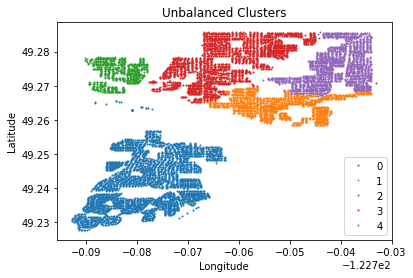

In [30]:
olddata = clusters.merge(coordinates)
groups = olddata.groupby("cluster")

for name, group in groups:
    

    plt.plot(group["long"], group["lat"], marker="o", linestyle="", label=name, markersize=1)
    plt.legend()
    plt.xlabel("Longitude")

    plt.ylabel("Latitude")
    plt.title('Unbalanced Clusters')
    plt.savefig('unbalancedClusters.png')

In [10]:
def adjustClusters(matrix,clusters, deviation, numElementsPerCluster):
    clusters = clusters.set_index('address')
    clusters['address'] = clusters.index
    
    numElementsInMin = clusters.groupby('cluster').nunique().sort_values(by='address').values[0][0]
    minCluster = clusters.groupby('cluster').nunique().sort_values(by='address').index[0]
    
    numElementsInMax = clusters.groupby('cluster').nunique().sort_values(by='address').values[-1][0]
    maxCluster = clusters.groupby('cluster').nunique().sort_values(by='address').index[-1]
    
    maxDeviation = not (numElementsInMax <= numElementsPerCluster + deviation and numElementsInMax >= numElementsPerCluster - deviation)
    minDeviation = not (numElementsInMin <= numElementsPerCluster + deviation and numElementsInMin >= numElementsPerCluster - deviation)
    
    while minDeviation or maxDeviation:
        
        # Determining the elements in the smallest and largest cluster
        minClusterElements = clusters[clusters['cluster'] ==  minCluster]['address']
        maxClusterElements = clusters[clusters['cluster'] ==  maxCluster]['address']      
          

        # Filtering the matrix so that the rows have only the min cluster elements and removing the min cluster
        # elements from the columns
        filteredMatrix = matrix.iloc[matrix.index.isin(minClusterElements.values),matrix.columns.isin(maxClusterElements.values)]
        
        # Determining the closest element to the min cluster
        closestElement = filteredMatrix.mean(axis=0).idxmin()
        
  
        clusters.loc[closestElement,'cluster'] = minCluster
        
        
        numElementsInMin = clusters.groupby('cluster').nunique().sort_values(by='address').values[0][0]
        minCluster = clusters.groupby('cluster').nunique().sort_values(by='address').index[0]

        numElementsInMax = clusters.groupby('cluster').nunique().sort_values(by='address').values[-1][0]
        maxCluster = clusters.groupby('cluster').nunique().sort_values(by='address').index[-1]



        maxDeviation = not (numElementsInMax <= numElementsPerCluster + deviation and numElementsInMax >= numElementsPerCluster - deviation)
        minDeviation = not (numElementsInMin <= numElementsPerCluster + deviation and numElementsInMin >= numElementsPerCluster - deviation)
        
        print(clusters.groupby('cluster').nunique().sort_values(by='address'))
        print("***********************************")

        
       



        
    return clusters
        
newClusters = adjustClusters(timeMatrix,clusters, 50, 1981)  
    
# newClusters = adjustClusters(t1,clusters, 3, 20)  

         address
cluster         
2            667
1           1423
4           1706
3           2499
0           3615
***********************************
         address
cluster         
2            668
1           1423
4           1706
3           2499
0           3614
***********************************
         address
cluster         
2            669
1           1423
4           1706
3           2499
0           3613
***********************************
         address
cluster         
2            670
1           1423
4           1706
3           2499
0           3612
***********************************
         address
cluster         
2            671
1           1423
4           1706
3           2499
0           3611
***********************************
         address
cluster         
2            672
1           1423
4           1706
3           2499
0           3610
***********************************
         address
cluster         
2            673
1           1423
4 

         address
cluster         
2            721
1           1423
4           1706
3           2499
0           3561
***********************************
         address
cluster         
2            722
1           1423
4           1706
3           2499
0           3560
***********************************
         address
cluster         
2            723
1           1423
4           1706
3           2499
0           3559
***********************************
         address
cluster         
2            724
1           1423
4           1706
3           2499
0           3558
***********************************
         address
cluster         
2            725
1           1423
4           1706
3           2499
0           3557
***********************************
         address
cluster         
2            726
1           1423
4           1706
3           2499
0           3556
***********************************
         address
cluster         
2            727
1           1423
4 

         address
cluster         
2            775
1           1423
4           1706
3           2499
0           3507
***********************************
         address
cluster         
2            776
1           1423
4           1706
3           2499
0           3506
***********************************
         address
cluster         
2            777
1           1423
4           1706
3           2499
0           3505
***********************************
         address
cluster         
2            778
1           1423
4           1706
3           2499
0           3504
***********************************
         address
cluster         
2            779
1           1423
4           1706
3           2499
0           3503
***********************************
         address
cluster         
2            780
1           1423
4           1706
3           2499
0           3502
***********************************
         address
cluster         
2            781
1           1423
4 

         address
cluster         
2            829
1           1423
4           1706
3           2499
0           3453
***********************************
         address
cluster         
2            830
1           1423
4           1706
3           2499
0           3452
***********************************
         address
cluster         
2            831
1           1423
4           1706
3           2499
0           3451
***********************************
         address
cluster         
2            832
1           1423
4           1706
3           2499
0           3450
***********************************
         address
cluster         
2            833
1           1423
4           1706
3           2499
0           3449
***********************************
         address
cluster         
2            834
1           1423
4           1706
3           2499
0           3448
***********************************
         address
cluster         
2            835
1           1423
4 

         address
cluster         
2            883
1           1423
4           1706
3           2499
0           3399
***********************************
         address
cluster         
2            884
1           1423
4           1706
3           2499
0           3398
***********************************
         address
cluster         
2            885
1           1423
4           1706
3           2499
0           3397
***********************************
         address
cluster         
2            886
1           1423
4           1706
3           2499
0           3396
***********************************
         address
cluster         
2            887
1           1423
4           1706
3           2499
0           3395
***********************************
         address
cluster         
2            888
1           1423
4           1706
3           2499
0           3394
***********************************
         address
cluster         
2            889
1           1423
4 

         address
cluster         
2            937
1           1423
4           1706
3           2499
0           3345
***********************************
         address
cluster         
2            938
1           1423
4           1706
3           2499
0           3344
***********************************
         address
cluster         
2            939
1           1423
4           1706
3           2499
0           3343
***********************************
         address
cluster         
2            940
1           1423
4           1706
3           2499
0           3342
***********************************
         address
cluster         
2            941
1           1423
4           1706
3           2499
0           3341
***********************************
         address
cluster         
2            942
1           1423
4           1706
3           2499
0           3340
***********************************
         address
cluster         
2            943
1           1423
4 

         address
cluster         
2            991
1           1423
4           1706
3           2499
0           3291
***********************************
         address
cluster         
2            992
1           1423
4           1706
3           2499
0           3290
***********************************
         address
cluster         
2            993
1           1423
4           1706
3           2499
0           3289
***********************************
         address
cluster         
2            994
1           1423
4           1706
3           2499
0           3288
***********************************
         address
cluster         
2            995
1           1423
4           1706
3           2499
0           3287
***********************************
         address
cluster         
2            996
1           1423
4           1706
3           2499
0           3286
***********************************
         address
cluster         
2            997
1           1423
4 

         address
cluster         
2           1045
1           1423
4           1706
3           2499
0           3237
***********************************
         address
cluster         
2           1046
1           1423
4           1706
3           2499
0           3236
***********************************
         address
cluster         
2           1047
1           1423
4           1706
3           2499
0           3235
***********************************
         address
cluster         
2           1048
1           1423
4           1706
3           2499
0           3234
***********************************
         address
cluster         
2           1049
1           1423
4           1706
3           2499
0           3233
***********************************
         address
cluster         
2           1050
1           1423
4           1706
3           2499
0           3232
***********************************
         address
cluster         
2           1051
1           1423
4 

         address
cluster         
2           1099
1           1423
4           1706
3           2499
0           3183
***********************************
         address
cluster         
2           1100
1           1423
4           1706
3           2499
0           3182
***********************************
         address
cluster         
2           1101
1           1423
4           1706
3           2499
0           3181
***********************************
         address
cluster         
2           1102
1           1423
4           1706
3           2499
0           3180
***********************************
         address
cluster         
2           1103
1           1423
4           1706
3           2499
0           3179
***********************************
         address
cluster         
2           1104
1           1423
4           1706
3           2499
0           3178
***********************************
         address
cluster         
2           1105
1           1423
4 

         address
cluster         
2           1153
1           1423
4           1706
3           2499
0           3129
***********************************
         address
cluster         
2           1154
1           1423
4           1706
3           2499
0           3128
***********************************
         address
cluster         
2           1155
1           1423
4           1706
3           2499
0           3127
***********************************
         address
cluster         
2           1156
1           1423
4           1706
3           2499
0           3126
***********************************
         address
cluster         
2           1157
1           1423
4           1706
3           2499
0           3125
***********************************
         address
cluster         
2           1158
1           1423
4           1706
3           2499
0           3124
***********************************
         address
cluster         
2           1159
1           1423
4 

         address
cluster         
2           1207
1           1423
4           1706
3           2499
0           3075
***********************************
         address
cluster         
2           1208
1           1423
4           1706
3           2499
0           3074
***********************************
         address
cluster         
2           1209
1           1423
4           1706
3           2499
0           3073
***********************************
         address
cluster         
2           1210
1           1423
4           1706
3           2499
0           3072
***********************************
         address
cluster         
2           1211
1           1423
4           1706
3           2499
0           3071
***********************************
         address
cluster         
2           1212
1           1423
4           1706
3           2499
0           3070
***********************************
         address
cluster         
2           1213
1           1423
4 

         address
cluster         
2           1261
1           1423
4           1706
3           2499
0           3021
***********************************
         address
cluster         
2           1262
1           1423
4           1706
3           2499
0           3020
***********************************
         address
cluster         
2           1263
1           1423
4           1706
3           2499
0           3019
***********************************
         address
cluster         
2           1264
1           1423
4           1706
3           2499
0           3018
***********************************
         address
cluster         
2           1265
1           1423
4           1706
3           2499
0           3017
***********************************
         address
cluster         
2           1266
1           1423
4           1706
3           2499
0           3016
***********************************
         address
cluster         
2           1267
1           1423
4 

         address
cluster         
2           1315
1           1423
4           1706
3           2499
0           2967
***********************************
         address
cluster         
2           1316
1           1423
4           1706
3           2499
0           2966
***********************************
         address
cluster         
2           1317
1           1423
4           1706
3           2499
0           2965
***********************************
         address
cluster         
2           1318
1           1423
4           1706
3           2499
0           2964
***********************************
         address
cluster         
2           1319
1           1423
4           1706
3           2499
0           2963
***********************************
         address
cluster         
2           1320
1           1423
4           1706
3           2499
0           2962
***********************************
         address
cluster         
2           1321
1           1423
4 

         address
cluster         
2           1369
1           1423
4           1706
3           2499
0           2913
***********************************
         address
cluster         
2           1370
1           1423
4           1706
3           2499
0           2912
***********************************
         address
cluster         
2           1371
1           1423
4           1706
3           2499
0           2911
***********************************
         address
cluster         
2           1372
1           1423
4           1706
3           2499
0           2910
***********************************
         address
cluster         
2           1373
1           1423
4           1706
3           2499
0           2909
***********************************
         address
cluster         
2           1374
1           1423
4           1706
3           2499
0           2908
***********************************
         address
cluster         
2           1375
1           1423
4 

         address
cluster         
1           1423
2           1423
4           1706
3           2499
0           2859
***********************************
         address
cluster         
2           1423
1           1424
4           1706
3           2499
0           2858
***********************************
         address
cluster         
1           1424
2           1424
4           1706
3           2499
0           2857
***********************************
         address
cluster         
2           1424
1           1425
4           1706
3           2499
0           2856
***********************************
         address
cluster         
1           1425
2           1425
4           1706
3           2499
0           2855
***********************************
         address
cluster         
2           1425
1           1426
4           1706
3           2499
0           2854
***********************************
         address
cluster         
1           1426
2           1426
4 

         address
cluster         
1           1450
2           1450
4           1706
3           2499
0           2805
***********************************
         address
cluster         
2           1450
1           1451
4           1706
3           2499
0           2804
***********************************
         address
cluster         
1           1451
2           1451
4           1706
3           2499
0           2803
***********************************
         address
cluster         
2           1451
1           1452
4           1706
3           2499
0           2802
***********************************
         address
cluster         
1           1452
2           1452
4           1706
3           2499
0           2801
***********************************
         address
cluster         
2           1452
1           1453
4           1706
3           2499
0           2800
***********************************
         address
cluster         
1           1453
2           1453
4 

         address
cluster         
1           1477
2           1477
4           1706
3           2499
0           2751
***********************************
         address
cluster         
2           1477
1           1478
4           1706
3           2499
0           2750
***********************************
         address
cluster         
1           1478
2           1478
4           1706
3           2499
0           2749
***********************************
         address
cluster         
2           1478
1           1479
4           1706
3           2499
0           2748
***********************************
         address
cluster         
1           1479
2           1479
4           1706
3           2499
0           2747
***********************************
         address
cluster         
2           1479
1           1480
4           1706
3           2499
0           2746
***********************************
         address
cluster         
1           1480
2           1480
4 

         address
cluster         
1           1504
2           1504
4           1706
3           2499
0           2697
***********************************
         address
cluster         
2           1504
1           1505
4           1706
3           2499
0           2696
***********************************
         address
cluster         
1           1505
2           1505
4           1706
3           2499
0           2695
***********************************
         address
cluster         
2           1505
1           1506
4           1706
3           2499
0           2694
***********************************
         address
cluster         
1           1506
2           1506
4           1706
3           2499
0           2693
***********************************
         address
cluster         
2           1506
1           1507
4           1706
3           2499
0           2692
***********************************
         address
cluster         
1           1507
2           1507
4 

         address
cluster         
1           1531
2           1531
4           1706
3           2499
0           2643
***********************************
         address
cluster         
2           1531
1           1532
4           1706
3           2499
0           2642
***********************************
         address
cluster         
1           1532
2           1532
4           1706
3           2499
0           2641
***********************************
         address
cluster         
2           1532
1           1533
4           1706
3           2499
0           2640
***********************************
         address
cluster         
1           1533
2           1533
4           1706
3           2499
0           2639
***********************************
         address
cluster         
2           1533
1           1534
4           1706
3           2499
0           2638
***********************************
         address
cluster         
1           1534
2           1534
4 

         address
cluster         
1           1558
2           1558
4           1706
3           2499
0           2589
***********************************
         address
cluster         
2           1558
1           1559
4           1706
3           2499
0           2588
***********************************
         address
cluster         
1           1559
2           1559
4           1706
3           2499
0           2587
***********************************
         address
cluster         
2           1559
1           1560
4           1706
3           2499
0           2586
***********************************
         address
cluster         
1           1560
2           1560
4           1706
3           2499
0           2585
***********************************
         address
cluster         
2           1560
1           1561
4           1706
3           2499
0           2584
***********************************
         address
cluster         
1           1561
2           1561
4 

         address
cluster         
1           1585
2           1585
4           1706
3           2499
0           2535
***********************************
         address
cluster         
2           1585
1           1586
4           1706
3           2499
0           2534
***********************************
         address
cluster         
1           1586
2           1586
4           1706
3           2499
0           2533
***********************************
         address
cluster         
2           1586
1           1587
4           1706
3           2499
0           2532
***********************************
         address
cluster         
1           1587
2           1587
4           1706
3           2499
0           2531
***********************************
         address
cluster         
2           1587
1           1588
4           1706
3           2499
0           2530
***********************************
         address
cluster         
1           1588
2           1588
4 

         address
cluster         
1           1612
2           1612
4           1706
0           2490
3           2490
***********************************
         address
cluster         
2           1612
1           1613
4           1706
3           2489
0           2490
***********************************
         address
cluster         
1           1613
2           1613
4           1706
0           2489
3           2489
***********************************
         address
cluster         
2           1613
1           1614
4           1706
3           2488
0           2489
***********************************
         address
cluster         
1           1614
2           1614
4           1706
0           2488
3           2488
***********************************
         address
cluster         
2           1614
1           1615
4           1706
3           2487
0           2488
***********************************
         address
cluster         
1           1615
2           1615
4 

         address
cluster         
1           1639
2           1639
4           1706
0           2463
3           2463
***********************************
         address
cluster         
2           1639
1           1640
4           1706
3           2462
0           2463
***********************************
         address
cluster         
1           1640
2           1640
4           1706
0           2462
3           2462
***********************************
         address
cluster         
2           1640
1           1641
4           1706
3           2461
0           2462
***********************************
         address
cluster         
1           1641
2           1641
4           1706
0           2461
3           2461
***********************************
         address
cluster         
2           1641
1           1642
4           1706
3           2460
0           2461
***********************************
         address
cluster         
1           1642
2           1642
4 

         address
cluster         
2           1665
1           1666
4           1706
3           2436
0           2437
***********************************
         address
cluster         
1           1666
2           1666
4           1706
0           2436
3           2436
***********************************
         address
cluster         
2           1666
1           1667
4           1706
3           2435
0           2436
***********************************
         address
cluster         
1           1667
2           1667
4           1706
0           2435
3           2435
***********************************
         address
cluster         
2           1667
1           1668
4           1706
3           2434
0           2435
***********************************
         address
cluster         
1           1668
2           1668
4           1706
0           2434
3           2434
***********************************
         address
cluster         
2           1668
1           1669
4 

         address
cluster         
1           1692
2           1692
4           1706
0           2410
3           2410
***********************************
         address
cluster         
2           1692
1           1693
4           1706
3           2409
0           2410
***********************************
         address
cluster         
1           1693
2           1693
4           1706
0           2409
3           2409
***********************************
         address
cluster         
2           1693
1           1694
4           1706
3           2408
0           2409
***********************************
         address
cluster         
1           1694
2           1694
4           1706
0           2408
3           2408
***********************************
         address
cluster         
2           1694
1           1695
4           1706
3           2407
0           2408
***********************************
         address
cluster         
1           1695
2           1695
4 

         address
cluster         
4           1714
1           1715
2           1715
0           2383
3           2383
***********************************
         address
cluster         
1           1715
2           1715
4           1715
3           2382
0           2383
***********************************
         address
cluster         
2           1715
4           1715
1           1716
0           2382
3           2382
***********************************
         address
cluster         
4           1715
1           1716
2           1716
3           2381
0           2382
***********************************
         address
cluster         
1           1716
2           1716
4           1716
0           2381
3           2381
***********************************
         address
cluster         
2           1716
4           1716
1           1717
3           2380
0           2381
***********************************
         address
cluster         
4           1716
1           1717
2 

         address
cluster         
4           1732
1           1733
2           1733
0           2356
3           2356
***********************************
         address
cluster         
1           1733
2           1733
4           1733
3           2355
0           2356
***********************************
         address
cluster         
2           1733
4           1733
1           1734
0           2355
3           2355
***********************************
         address
cluster         
4           1733
1           1734
2           1734
3           2354
0           2355
***********************************
         address
cluster         
1           1734
2           1734
4           1734
0           2354
3           2354
***********************************
         address
cluster         
2           1734
4           1734
1           1735
3           2353
0           2354
***********************************
         address
cluster         
4           1734
1           1735
2 

         address
cluster         
4           1750
1           1751
2           1751
0           2329
3           2329
***********************************
         address
cluster         
1           1751
2           1751
4           1751
3           2328
0           2329
***********************************
         address
cluster         
2           1751
4           1751
1           1752
0           2328
3           2328
***********************************
         address
cluster         
4           1751
1           1752
2           1752
3           2327
0           2328
***********************************
         address
cluster         
1           1752
2           1752
4           1752
0           2327
3           2327
***********************************
         address
cluster         
2           1752
4           1752
1           1753
3           2326
0           2327
***********************************
         address
cluster         
4           1752
1           1753
2 

         address
cluster         
4           1768
1           1769
2           1769
0           2302
3           2302
***********************************
         address
cluster         
1           1769
2           1769
4           1769
3           2301
0           2302
***********************************
         address
cluster         
2           1769
4           1769
1           1770
0           2301
3           2301
***********************************
         address
cluster         
4           1769
1           1770
2           1770
3           2300
0           2301
***********************************
         address
cluster         
1           1770
2           1770
4           1770
0           2300
3           2300
***********************************
         address
cluster         
2           1770
4           1770
1           1771
3           2299
0           2300
***********************************
         address
cluster         
4           1770
1           1771
2 

         address
cluster         
4           1786
1           1787
2           1787
0           2275
3           2275
***********************************
         address
cluster         
1           1787
2           1787
4           1787
3           2274
0           2275
***********************************
         address
cluster         
2           1787
4           1787
1           1788
0           2274
3           2274
***********************************
         address
cluster         
4           1787
1           1788
2           1788
3           2273
0           2274
***********************************
         address
cluster         
1           1788
2           1788
4           1788
0           2273
3           2273
***********************************
         address
cluster         
2           1788
4           1788
1           1789
3           2272
0           2273
***********************************
         address
cluster         
4           1788
1           1789
2 

         address
cluster         
4           1804
1           1805
2           1805
0           2248
3           2248
***********************************
         address
cluster         
1           1805
2           1805
4           1805
3           2247
0           2248
***********************************
         address
cluster         
2           1805
4           1805
1           1806
0           2247
3           2247
***********************************
         address
cluster         
4           1805
1           1806
2           1806
3           2246
0           2247
***********************************
         address
cluster         
1           1806
2           1806
4           1806
0           2246
3           2246
***********************************
         address
cluster         
2           1806
4           1806
1           1807
3           2245
0           2246
***********************************
         address
cluster         
4           1806
1           1807
2 

         address
cluster         
4           1822
1           1823
2           1823
0           2221
3           2221
***********************************
         address
cluster         
1           1823
2           1823
4           1823
3           2220
0           2221
***********************************
         address
cluster         
2           1823
4           1823
1           1824
0           2220
3           2220
***********************************
         address
cluster         
4           1823
1           1824
2           1824
3           2219
0           2220
***********************************
         address
cluster         
1           1824
2           1824
4           1824
0           2219
3           2219
***********************************
         address
cluster         
2           1824
4           1824
1           1825
3           2218
0           2219
***********************************
         address
cluster         
4           1824
1           1825
2 

         address
cluster         
4           1840
1           1841
2           1841
0           2194
3           2194
***********************************
         address
cluster         
1           1841
2           1841
4           1841
3           2193
0           2194
***********************************
         address
cluster         
2           1841
4           1841
1           1842
0           2193
3           2193
***********************************
         address
cluster         
4           1841
1           1842
2           1842
3           2192
0           2193
***********************************
         address
cluster         
1           1842
2           1842
4           1842
0           2192
3           2192
***********************************
         address
cluster         
2           1842
4           1842
1           1843
3           2191
0           2192
***********************************
         address
cluster         
4           1842
1           1843
2 

         address
cluster         
4           1858
1           1859
2           1859
0           2167
3           2167
***********************************
         address
cluster         
1           1859
2           1859
4           1859
3           2166
0           2167
***********************************
         address
cluster         
2           1859
4           1859
1           1860
0           2166
3           2166
***********************************
         address
cluster         
4           1859
1           1860
2           1860
3           2165
0           2166
***********************************
         address
cluster         
1           1860
2           1860
4           1860
0           2165
3           2165
***********************************
         address
cluster         
2           1860
4           1860
1           1861
3           2164
0           2165
***********************************
         address
cluster         
4           1860
1           1861
2 

         address
cluster         
4           1876
1           1877
2           1877
0           2140
3           2140
***********************************
         address
cluster         
1           1877
2           1877
4           1877
3           2139
0           2140
***********************************
         address
cluster         
2           1877
4           1877
1           1878
0           2139
3           2139
***********************************
         address
cluster         
4           1877
1           1878
2           1878
3           2138
0           2139
***********************************
         address
cluster         
1           1878
2           1878
4           1878
0           2138
3           2138
***********************************
         address
cluster         
2           1878
4           1878
1           1879
3           2137
0           2138
***********************************
         address
cluster         
4           1878
1           1879
2 

         address
cluster         
4           1894
1           1895
2           1895
0           2113
3           2113
***********************************
         address
cluster         
1           1895
2           1895
4           1895
3           2112
0           2113
***********************************
         address
cluster         
2           1895
4           1895
1           1896
0           2112
3           2112
***********************************
         address
cluster         
4           1895
1           1896
2           1896
3           2111
0           2112
***********************************
         address
cluster         
1           1896
2           1896
4           1896
0           2111
3           2111
***********************************
         address
cluster         
2           1896
4           1896
1           1897
3           2110
0           2111
***********************************
         address
cluster         
4           1896
1           1897
2 

         address
cluster         
4           1912
1           1913
2           1913
0           2086
3           2086
***********************************
         address
cluster         
1           1913
2           1913
4           1913
3           2085
0           2086
***********************************
         address
cluster         
2           1913
4           1913
1           1914
0           2085
3           2085
***********************************
         address
cluster         
4           1913
1           1914
2           1914
3           2084
0           2085
***********************************
         address
cluster         
1           1914
2           1914
4           1914
0           2084
3           2084
***********************************
         address
cluster         
2           1914
4           1914
1           1915
3           2083
0           2084
***********************************
         address
cluster         
4           1914
1           1915
2 

         address
cluster         
2           1930
4           1930
1           1931
3           2059
0           2060
***********************************
         address
cluster         
4           1930
1           1931
2           1931
0           2059
3           2059
***********************************
         address
cluster         
1           1931
2           1931
4           1931
3           2058
0           2059
***********************************
         address
cluster         
2           1931
4           1931
1           1932
0           2058
3           2058
***********************************
         address
cluster         
4           1931
1           1932
2           1932
3           2057
0           2058
***********************************
         address
cluster         
1           1932
2           1932
4           1932
0           2057
3           2057
***********************************
         address
cluster         
2           1932
4           1932
1 

         address
cluster         
2           1948
4           1948
1           1949
3           2032
0           2033
***********************************
         address
cluster         
4           1948
1           1949
2           1949
0           2032
3           2032
***********************************
         address
cluster         
1           1949
2           1949
4           1949
3           2031
0           2032
***********************************
         address
cluster         
2           1949
4           1949
1           1950
0           2031
3           2031
***********************************


In [18]:
newClusters.groupby('cluster').nunique().sort_values(by='address')

,address
cluster,
2,1949
4,1949
1,1950
0,2031
3,2031


In [11]:
coordinates = pd.read_csv('C:/Users/Aidan/OneDrive - Simon Fraser University (1sfu)/Garbage Route Optimization/locations.csv')
coordinates = coordinates.rename(columns={'Unnamed: 0':'address'})

In [12]:
newClusters = newClusters.reset_index(drop=True)

In [13]:
data = newClusters.merge(coordinates)

In [14]:
data

,cluster,address,lat,long
0,4,"1608 STELLA PL, Port Coquitlam, BC, Canada",49.245147,-122.775298
1,0,"1131 CASTLE CRES, Port Coquitlam, BC, Canada",49.233161,-122.777057
2,2,"1788 MARY HILL RD, Port Coquitlam, BC, Canada",49.249363,-122.780524
3,0,"1239 KNIGHTS CRT, Port Coquitlam, BC, Canada",49.236590,-122.779497
4,4,"2075 ROUTLEY AVE, Port Coquitlam, BC, Canada",49.240582,-122.773638
...,...,...,...,...
9912,0,"2166 DRAWBRIDGE CLOSE, Port Coquitlam, BC, Canada",49.231026,-122.777781
9913,1,"2956 PARANA PL, Port Coquitlam, BC, Canada",49.266903,-122.742294
9914,4,"3055 SANDLEWOOD WAY, Port Coquitlam, BC, Canada",49.268401,-122.749410
9915,1,"1382 RHINE CLOSE, Port Coquitlam, BC, Canada",49.263973,-122.751553


In [15]:
data.head()

,cluster,address,lat,long
0,4,"1608 STELLA PL, Port Coquitlam, BC, Canada",49.245147,-122.775298
1,0,"1131 CASTLE CRES, Port Coquitlam, BC, Canada",49.233161,-122.777057
2,2,"1788 MARY HILL RD, Port Coquitlam, BC, Canada",49.249363,-122.780524
3,0,"1239 KNIGHTS CRT, Port Coquitlam, BC, Canada",49.236590,-122.779497
4,4,"2075 ROUTLEY AVE, Port Coquitlam, BC, Canada",49.240582,-122.773638


In [16]:
import matplotlib.pyplot as plt

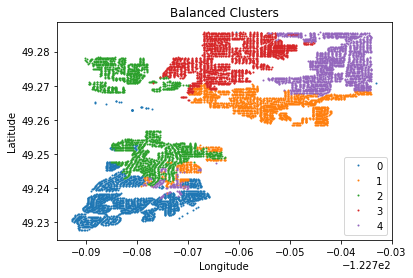

In [26]:
groups = data.groupby("cluster")

for name, group in groups:
    

    plt.plot(group["long"], group["lat"], marker="o", linestyle="", label=name, markersize=1)
plt.legend()
plt.xlabel("Longitude")

plt.ylabel("Latitude")
plt.title('Balanced Clusters')
plt.savefig('balancedClusters.png')

In [22]:
locations = pd.read_csv('C:/Users/Aidan/OneDrive - Simon Fraser University (1sfu)/Garbage Route Optimization/locations.csv')
locations = locations.rename(columns={'Unnamed: 0':'address'})

In [ ]:
locations[(locations['lat'] > 49.245) & (locations['lat'] > 49.250)]

In [ ]:
t = pd.read_csv('C:/Users/Aidan/OneDrive - Simon Fraser University (1sfu)/Garbage Route Optimization/timeMatrix.csv', index_col=0)

In [32]:
locations = locations[locations['address'].isin(zones.index)]

In [38]:
locations = locations.sort_values(by=['lat'],ascending=True)
locations = locations.sort_values(by=['long'],ascending=True)

In [47]:
timeMatrix[timeMatrix.index.isin(clusterElements)].mean(axis=0).idxmin()

'927 FORT FRASER RISE, Port Coquitlam, BC, Canada'

In [168]:
numElements = 1
clusterElements = ['927 FORT FRASER RISE, Port Coquitlam, BC, Canada']
while numElements < 1807:
    
    t = timeMatrix.iloc[timeMatrix.index.isin(clusterElements),
                                 ~timeMatrix.columns.isin(clusterElements)].idxmin(axis=1)
    

    m = ('NA',100000000000000000000000000000)
    for i in range(0,len(t)):
        minTimes = timeMatrix.loc[t.index[i],t[i]]
        if m[1] >  minTimes:
            m = (t[i], minTimes)
    
    clusterElements.append(m[0])
    numElements += 1
    
#     print(clusterElements)
#     if numElements > 2:
#         break
 
    if numElements % 100 == 0:
        print(numElements)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800


In [157]:
t = timeMatrix.iloc[timeMatrix.index.isin(clusterElements),
                                 ~timeMatrix.columns.isin(clusterElements)].idxmin(axis=1)

for i in range(0,len(t)):
    minTimes = timeMatrix.loc[t.index[i],t[i]]
    if m[1] >  minTimes:
        m = (t[i], minTimes)
        
print(m)

2.0
1000000000000000000000
fdsa
1.0
2.0
fdsa
('932 FORT FRASER RISE, Port Coquitlam, BC, Canada', 1.0)


In [110]:
sum(t.columns.values == '927 FORT FRASER RISE, Port Coquitlam, BC, Canada')

0

In [99]:
timeMatrix

,"1608 STELLA PL, Port Coquitlam, BC, Canada","1131 CASTLE CRES, Port Coquitlam, BC, Canada","1788 MARY HILL RD, Port Coquitlam, BC, Canada","1239 KNIGHTS CRT, Port Coquitlam, BC, Canada","2075 ROUTLEY AVE, Port Coquitlam, BC, Canada","2359 BEGBIE TERR, Port Coquitlam, BC, Canada","2117 AUDREY DR, Port Coquitlam, BC, Canada","1846 SCARBOROUGH CRES, Port Coquitlam, BC, Canada","2670 PIONEER WAY, Port Coquitlam, BC, Canada","2060 SHAUGHNESSY ST, Port Coquitlam, BC, Canada",...,"1551 WESTERN DR, Port Coquitlam, BC, Canada","1662 KNAPPEN ST, Port Coquitlam, BC, Canada","1131 EARLS CRT, Port Coquitlam, BC, Canada","1112 CASTLE CRES, Port Coquitlam, BC, Canada","1657 EASTERN DR, Port Coquitlam, BC, Canada","2270 RAMPART PL, Port Coquitlam, BC, Canada","2654 KLASSEN CRT, Port Coquitlam, BC, Canada","2642 FORTRESS DR, Port Coquitlam, BC, Canada","840 MUSKET TERR, Port Coquitlam, BC, Canada","2166 DRAWBRIDGE CLOSE, Port Coquitlam, BC, Canada"
"1608 STELLA PL, Port Coquitlam, BC, Canada",0.0,241.0,169.0,200.0,79.0,248.0,96.0,121.0,305.0,201.0,...,157.0,75.0,197.0,234.0,82.0,241.0,243.0,303.0,282.0,257.0
"1131 CASTLE CRES, Port Coquitlam, BC, Canada",241.0,0.0,318.0,125.0,177.0,125.0,287.0,294.0,180.0,367.0,...,238.0,245.0,122.0,9.0,273.0,31.0,260.0,178.0,157.0,55.0
"1788 MARY HILL RD, Port Coquitlam, BC, Canada",169.0,318.0,0.0,319.0,198.0,282.0,97.0,142.0,248.0,83.0,...,80.0,194.0,316.0,311.0,121.0,318.0,166.0,323.0,302.0,334.0
"1239 KNIGHTS CRT, Port Coquitlam, BC, Canada",200.0,125.0,319.0,0.0,136.0,132.0,246.0,253.0,189.0,326.0,...,245.0,204.0,27.0,118.0,232.0,125.0,267.0,187.0,166.0,141.0
"2075 ROUTLEY AVE, Port Coquitlam, BC, Canada",79.0,177.0,198.0,136.0,0.0,184.0,125.0,132.0,241.0,205.0,...,186.0,83.0,133.0,170.0,111.0,177.0,272.0,239.0,218.0,193.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"2270 RAMPART PL, Port Coquitlam, BC, Canada",241.0,31.0,318.0,125.0,177.0,125.0,287.0,294.0,180.0,367.0,...,238.0,245.0,122.0,22.0,273.0,0.0,260.0,178.0,157.0,65.0
"2654 KLASSEN CRT, Port Coquitlam, BC, Canada",243.0,260.0,166.0,267.0,272.0,224.0,153.0,230.0,169.0,249.0,...,86.0,268.0,264.0,253.0,195.0,260.0,0.0,256.0,235.0,276.0
"2642 FORTRESS DR, Port Coquitlam, BC, Canada",303.0,178.0,323.0,187.0,239.0,186.0,310.0,356.0,156.0,406.0,...,243.0,307.0,184.0,171.0,335.0,178.0,256.0,0.0,71.0,194.0
"840 MUSKET TERR, Port Coquitlam, BC, Canada",282.0,157.0,302.0,166.0,218.0,165.0,289.0,335.0,135.0,385.0,...,222.0,286.0,163.0,150.0,314.0,157.0,235.0,71.0,0.0,173.0


In [169]:
import numpy as np
df1 = locations[locations['address'].isin(clusterElements)]
df1['cluster'] = 0

<ipython-input-169-fca10a7db9c5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['cluster'] = 0


In [170]:
df2 = locations[~locations['address'].isin(clusterElements)]
df2['cluster'] = 1

<ipython-input-170-6049389239c0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['cluster'] = 1


In [171]:
df = pd.concat([df1,df2])

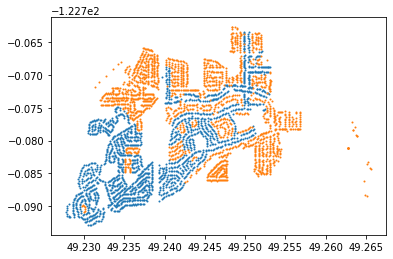

In [172]:
groups = df.groupby("cluster")

for name, group in groups:
    

    plt.plot(group["lat"], group["long"], marker="o", linestyle="", label=name, markersize=1)